In [42]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import os
import PIL
import PIL.Image
import imageio
import imgaug as ia
import random

from pathlib import Path
from numpy import asarray
from imgaug import augmenters as iaa
from tensorflow import keras
from keras import backend as K
from keras import layers
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize

In [43]:
train_data_path = '../../sensix_daninhas/datasetpericles/train'
test_data_path  = '../../sensix_daninhas/datasetpericles/validation'

img_rows = 100
img_cols = 100
epochs = 500
batch_size = 10
n_channels = 3

In [44]:
num_of_train_samples = len(glob.glob(train_data_path + "/**/*" + ".jpg" , recursive=True))
num_of_test_samples  = len(glob.glob(test_data_path + "/**/*" + ".jpg"  , recursive=True))
print("Train Images : ", num_of_train_samples)
print("Test Images  : ", num_of_test_samples)

Train Images :  2630
Test Images  :  629


In [45]:
def random_func(*, percentage: int) -> int:
    '''
    percentage: Valores entre 0 e 100. Caso percentage > _value é retornado true, caso não
    é retornado false
    
    description: Utilizada para definir se a função de pré processamento será utilizada ou
    não. 
    
    return:
    bool
    '''
    _value = random.randint(0, 100)
    if _value < percentage:
        #print(_value)
        return False
    else:
        #print(_value)
        return True

In [46]:
def prepare_dataset(img):
    '''
    img: array que representa a imagem que será modifiada:
    
    description: Utilizada para definir qual função de pré processamento será utilizada,
    cada intervalo representa um tipo de função a ser chamada. 
    [0  10] - imagem não transformada 
    [11 39] - prepare_dataset_func_1(img)
    [40 69] - prepare_dataset_func_2(img)
    [70 ..] - prepare_dataset_func_3(img)
    
    return: array
    O array retornado representa a imagem modificada ou não
    '''
    _choose_func = random_func()
    if _choose_func < 10:
        #print('fun 0')
        return img
    elif _choose_func  >= 10 and _choose_func < 40 :
        _img = prepare_dataset_func_1(img)
        #print('fun 1')
        return _img
    elif _choose_func  >= 40 and _choose_func < 70 :
        _img = prepare_dataset_func_2(img)
        #print('fun 2')
        return _img
    else:
        _img = prepare_dataset_func_3(img)
        #print('fun 3')
        return _img

In [47]:
def prepare_dataset_func_1(img):
    '''
    img: array que representa a imagem que será modificada:
    
    description: Representa efeitos relacionados a coloração da imagem. Nenhuma
    rotação ou aproximação (zoom) é dado. Apenas possui filtros que alteram as 
    caracteristicas gerais das imagens
    
    return: array
    O array retornado representa a imagem modificada
    '''
    img = img.astype('uint8')
    if random_func(percentage = 10):
        seq = iaa.Sequential([
            #iaa.Affine(rotate=(0, 90)),
            #iaa.Crop(percent=(0.1, 0.2)),
            iaa.LinearContrast((1.0, 1.9)),
            iaa.Multiply((0.8, 1.2), per_channel=0.2),
            iaa.AdditiveGaussianNoise(scale=(10, 20)),
            #iaa.Crop(percent=(0, 0.2)),
            iaa.AddToBrightness((-30, 30)),
            iaa.AddToHue((-50, 50)),
            iaa.flip.Fliplr(0.5)
            #iaa.AllChannelsHistogramEqualization()
        ],
        random_order=True)
        images_aug = seq(image=img)
    else:
        images_aug = img
    
    images_aug = np.expand_dims(images_aug, axis=0)
    images_aug = images_aug.astype('float32')
    return (images_aug)

In [48]:
def prepare_dataset_func_2(img):
    '''
    img: array que representa a imagem que será modifiada:
    
    description: Representa efeitos relacionados a coloração da imagem, porém é 
    uma versão reduzida da prepare_dataset_func_1, aplicando apenas alterações
    nas cores dos canais RGB e modificações leves de contraste.
    
    return: array
    O array retornado representa a imagem modificada
    '''
    img = img.astype('uint8')
    seq = iaa.Sequential([
        iaa.WithChannels(2, [
            iaa.Multiply((0.5, 1.0)),
            iaa.LinearContrast((0.75, 1.25))
        ])
        
    ],
    random_order=True)

    images_aug = seq(image=img)
    images_aug = np.expand_dims(images_aug, axis=0)
    images_aug = images_aug.astype('float32')
    return (images_aug)

In [49]:
def prepare_dataset_func_3(img):
    '''
    img: array que representa a imagem que será modifiada:
    
    description: Representa efeitos relacionados as dimensões das imagens.
    São aplicadas rotações, aproximações (zoom), alteração aleátoria da cor
    do fundo da imagem, translação e rotação de imagens.
    
    return: array
    O array retornado representa a imagem modificada
    '''
    img = img.astype('uint8')
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential([
        sometimes(iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-45, 45),
        shear=(-16, 16),
        order=[0, 1],
        cval=(0, 255),
        mode=ia.ALL))
    ],
    random_order=True)

    images_aug = seq(image=img)
    images_aug = np.expand_dims(images_aug, axis=0)
    images_aug = images_aug.astype('float32')
    return (images_aug)

In [50]:
def prepare_dataset_func_4(img):
    '''
    img : array que representa a imagem que será modifiada:
    
    description: Serve apenas para chamar a vari_func
    
    return: array
    O array retornado representa a imagem modificada pela vari_func
    '''
    images_aug = vari_func(img, ch1 = 'green', ch2 = 'red', ch3 = 'blue', v_center=2)
    return (images_aug)

In [51]:
from PIL import Image  
from matplotlib import colors
import PIL  
from numpy import asarray

import matplotlib.pyplot as plt
import numpy as np
import cv2

def vari_func(img, ch1 = 'red', ch2 = 'green', ch3 = 'blue', v_min = 0, v_max = 10, v_center = 5, plot = False):
    '''
    img : array que representa a imagem que será modifiada:
    ch1, ch2, ch3 : canais utilizagos na imagem : Ex: ch1 = red, ch2 = green
    v_min : Representa os intervalos máximos e mínimos, apenas necessário na
    visualização do plot da imagem, que é quando plot é true
    plot : Necessário para plotar ou não a imagem modificada com o seu VARI
    
    description: Efetua o calcuo do (VARI), Índice Resistente à Atmosfera na 
    Região Visível e retorna a imagem modificada pelo VARI.
    
    return: array
    O array retornado representa a imagem modificada
    '''
    _r,_g,_b = cv2.split(img)
    _vari = (_g - _r) / ( _g + _r - _b)
    _vari = np.stack((_vari,)*n_channels, axis=-1)
    if plot:
        _cmap = colors.LinearSegmentedColormap.from_list('', [ch1, ch2, ch3])
        _norm = colors.DivergingNorm(vmin=v_min, vcenter=v_center, vmax=v_max)
        _n_img = plt.imshow(_vari.astype(np.float64), cmap=_cmap, norm=_norm)
        plt.axis('off')
    return _vari

In [52]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   preprocessing_function=prepare_dataset_func_1,
                                   fill_mode='constant',
                                   #validation_split=0.2,
                                   #horizontal_flip=True,
                                   #vertical_flip=True,
                                   )

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  #preprocessing_function=prepare_dataset_func_1,
                                  #fill_mode='constant',
                                  #horizontal_flip=True,
                                  #vertical_flip=True,
                                  )


train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    #subset='training',
                                                    #save_to_dir='genereted_train',
                                                    #save_prefix = 'train'
                                                    )

validation_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=(img_rows, img_cols),
                                                        batch_size=batch_size,
                                                        class_mode='binary',
                                                        #subset='validation',
                                                        #save_to_dir='genereted_val',
                                                        #save_prefix = 'val-'
                                                       )



Found 2630 images belonging to 2 classes.
Found 629 images belonging to 2 classes.


In [70]:
visible = tf.keras.layers.Input(shape=(img_rows, img_cols, n_channels))
conv1 = tf.keras.layers.Conv2D(8, (3,3), activation='relu')(visible)
pooling1 = tf.keras.layers.MaxPooling2D(2, 2)(conv1)
conv2 = tf.keras.layers.Conv2D(16, (3,3), activation='relu')(pooling1)
pooling2 = tf.keras.layers.MaxPooling2D(2,2)(conv2)
#conv3 = tf.keras.layers.Conv2D(16, (3,3), activation='relu')(pooling2)
#pooling3 = tf.keras.layers.MaxPooling2D(2,2)(conv3)
conv4 = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(pooling2)
pooling4 = tf.keras.layers.MaxPooling2D(2,2)(conv4)
flat = tf.keras.layers.Flatten()(pooling4)
hidden1 = tf.keras.layers.Dense(64, activation='relu')(flat)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hidden1)

model = tf.keras.Model(inputs=visible, outputs=out)
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 98, 98, 8)         224       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 49, 49, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 47, 47, 16)        1168      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 21, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 10, 10, 32)        0   

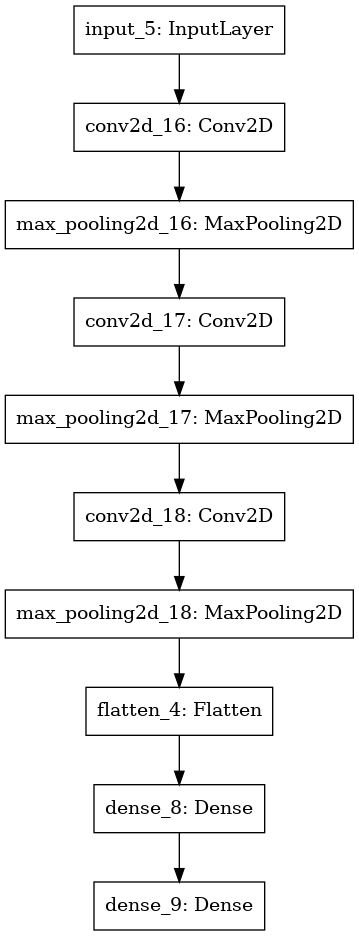

In [71]:
from keras.utils import plot_model
plot_model(model, to_file='convolutional_neural_network.png')

In [74]:
class CallbackStop(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        _percent = 0.92
        tf.keras.callbacks.TensorBoard(log_dir='logs')
        if logs.get('val_accuracy') is not None and logs.get('accuracy') and logs.get('val_accuracy') > _percent and logs.get('accuracy') > _percent:
            print("\nO treino foi cancelado, obtido mais de",_percent," de accuracy!", "\n")
            self.model.stop_training = True

In [75]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

callbacks = CallbackStop()

history = model.fit(train_generator,
                    steps_per_epoch= num_of_train_samples // batch_size,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=num_of_test_samples // batch_size,
                    callbacks=[callbacks]
                    )

Epoch 1/100
263/263 [==============================] - 16s 58ms/step - loss: 0.6104 - accuracy: 0.7276 - val_loss: 0.5212 - val_accuracy: 0.7887
Epoch 2/100
263/263 [==============================] - 16s 62ms/step - loss: 0.5466 - accuracy: 0.7559 - val_loss: 0.5135 - val_accuracy: 0.7952
Epoch 3/100
263/263 [==============================] - 16s 61ms/step - loss: 0.4808 - accuracy: 0.8199 - val_loss: 0.4461 - val_accuracy: 0.8258
Epoch 4/100
263/263 [==============================] - 15s 57ms/step - loss: 0.4840 - accuracy: 0.8195 - val_loss: 0.3998 - val_accuracy: 0.8532
Epoch 5/100
263/263 [==============================] - 17s 64ms/step - loss: 0.4455 - accuracy: 0.8405 - val_loss: 0.3514 - val_accuracy: 0.8516
Epoch 6/100
263/263 [==============================] - 16s 61ms/step - loss: 0.4025 - accuracy: 0.8487 - val_loss: 0.2687 - val_accuracy: 0.9226
Epoch 7/100
263/263 [==============================] - 16s 61ms/step - loss: 0.3836 - accuracy: 0.8585 - val_loss: 0.3459 - val_ac

In [76]:
Y_pred_model = model.predict(validation_generator, num_of_test_samples // batch_size)
y_pred_model = np.argmax(Y_pred_model, axis=1)
#print("Real :       ", validation_generator.classes)
#print("Prediction : ", y_pred_model)
print(confusion_matrix(validation_generator.classes, y_pred_model))

[[469   0]
 [160   0]]


(1, 98, 98, 8)
(1, 49, 49, 8)
(1, 47, 47, 16)
(1, 23, 23, 16)
(1, 21, 21, 32)
(1, 10, 10, 32)
(1, 3200)
(1, 64)
(1, 1)


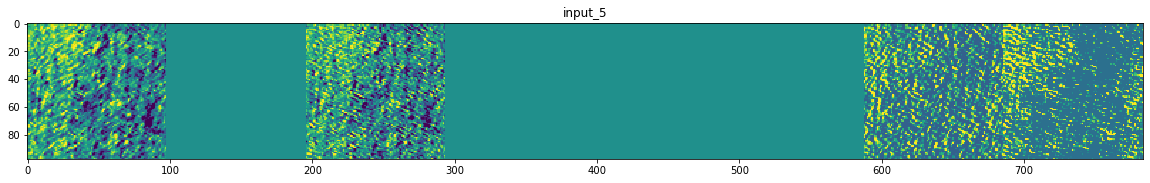

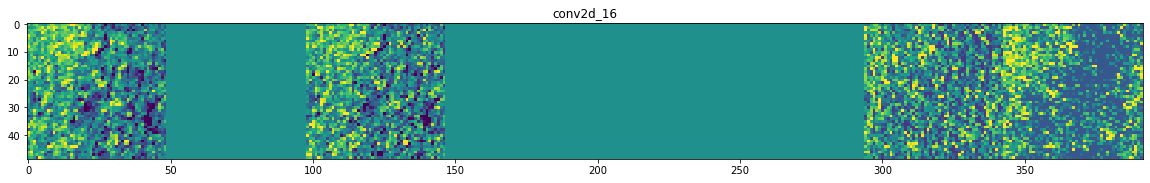

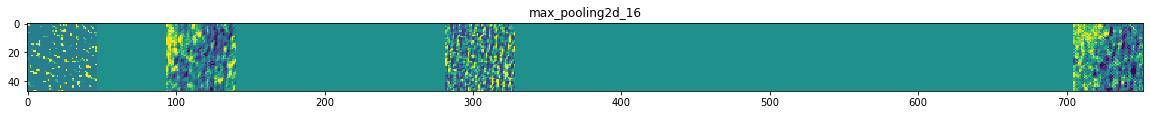

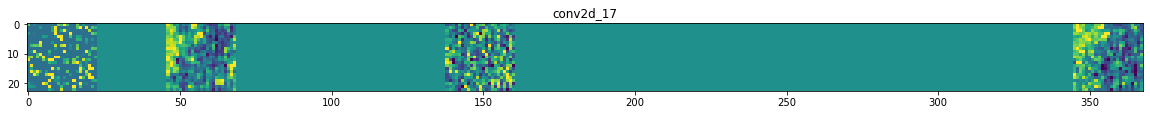

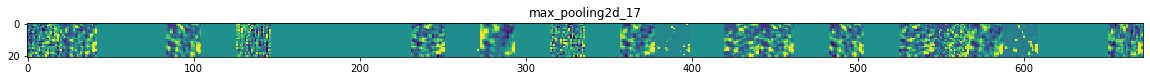

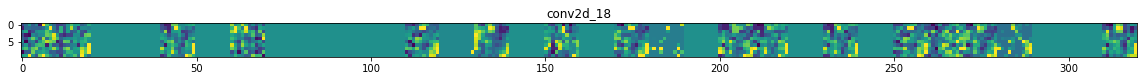

In [77]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
import os
import numpy as np
import matplotlib.pyplot as plt

img_path='../../sensix_daninhas/datasetpericles/test/daninha_12500_2400.jpg'
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)#Load the input image
img = load_img(img_path, target_size=(100, 100))# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)# Rescale by 1/255
x /= 255.0# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        if x.std()>0:
                x /= x.std()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        # Tile each filter into a horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

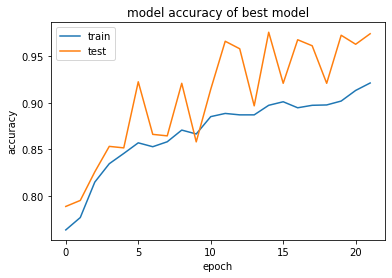

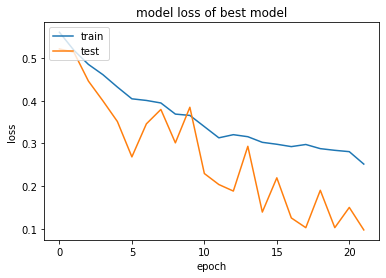

In [78]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of best model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss of best model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [79]:
image_path = '../../sensix_daninhas/datasetpericles/test/'

images = []

for img in os.listdir(image_path):
        img = os.path.join(image_path, img)
        img = image.load_img(img, target_size=(100,100))
        img = image.img_to_array(img)
        #print(img)
        img = np.expand_dims(img, axis=0)
        processed_image = np.array(img, dtype="float")
        images.append(processed_image)
        
images = np.vstack(images)
print(len(images))

27


count_daninha 11
count_sem_daninha 16


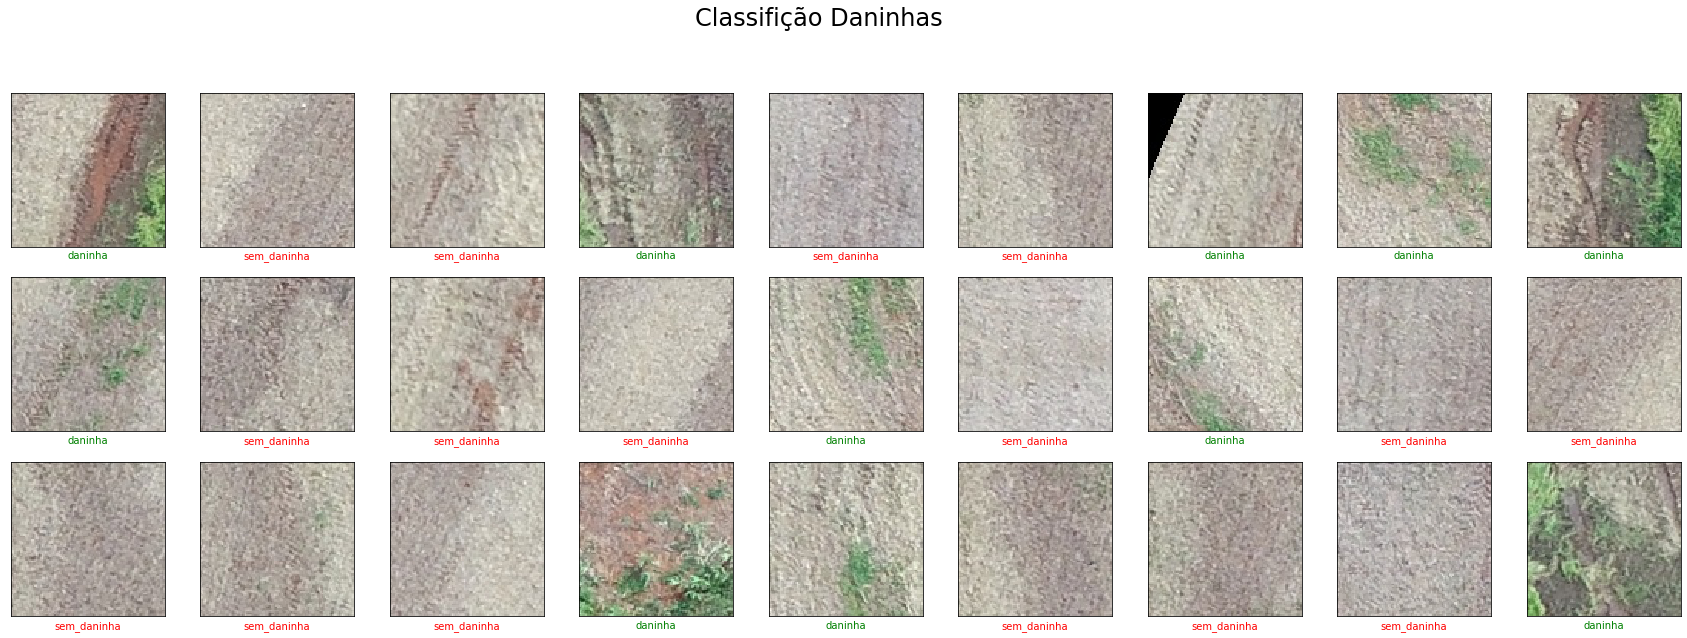

In [83]:
images_data = []
filenames = []
count_daninha = 0
count_sem_daninha = 0
count = 0
pred_result = model.predict(images)
#print(pred_result)
plt.figure(figsize=(30,30))
grid_size = min(0, len(pred_result))

for filename in os.listdir(image_path):
    images_data.append(pred_result)
    filenames.append(filename)
    plt.subplot(9, 9, count+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[count].astype(np.int32), cmap=plt.cm.binary)
    if pred_result[count]> 0.5:
        legend_x = plt.xlabel("daninha")
        legend_x.set_color("green")
        count_daninha = count_daninha + 1
        if count >= num_of_test_samples:
            break
    else :
        legend_x = plt.xlabel("sem_daninha")
        legend_x.set_color("red")
        count_sem_daninha = count_sem_daninha + 1
    count += 1

print("count_daninha", count_daninha)
print("count_sem_daninha", count_sem_daninha)
plt.suptitle('Classifição Daninhas', y = 0.92, fontsize=24)
plt.show(images_data)

In [84]:
model.save("danadinhas_new_data.h5")